Con uso de la libreria de `pandas`, importamos la base de datos `A1.6 Tiempo de Entrega.csv` para continar con nuestro analisis. A continuacion se muestran los tipos de datos de cada variable dentro de nuestro DataFrame. Durante el intento de importar la base de datos, ocurrieron varios errores y de manera manual indage dentro de los datos que habia y me di cuenta de varias cosas. 1- habia datos no mumericos, entre ellos espacios en blanco y de caracter especial. 2- habia varios outliers que se presentaban como valores negativos donde solo podia haber positivos y un numero demasiado grande para lo que estamos haciendo. Para solucionar esto, primero identificamos los valores especiales cambiandolo todo a numero, al ser caracter lo que hara el sistema es vaciar el campo, despues borramos las observaciones con campos vacios al ser una cantidad poco significativa para nuestras obvervaciones. Y para solucionar los outliers, acudimos a una prueba de Tukey donde sacamos el rango intercuartil y buscamos esos datos que esten fuera de este rango para de igual manera borrarlos. Una vez  hecho esto, graficamos nuestros datos de Calificaciones en relacion a Tiempo.
Viendo los datos sin algun modelo aun, pareciera ser una curva / triangulo, como si del comportamiento de una cuadratica se tratace.

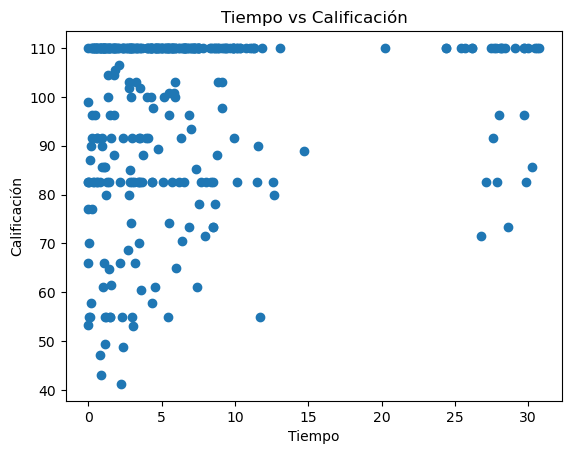

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("A1.6 Tiempo de Entrega.csv")

# Intentamos convertir a numérico, lo que no se pueda será NaN
df["Tiempo"] = pd.to_numeric(df["Tiempo"], errors="coerce")
df["Calificacion"] = pd.to_numeric(df["Calificacion"], errors="coerce")

# Quitamos filas vacias o nan
df = df.dropna()

# Metemos la prueba de Tueky en una funcion pa ver cuales son ls outliers
def eliminar_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    li = Q1 - 1.5 * IQR
    ls = Q3 + 1.5 * IQR
    return df[(df[col] >= li) & (df[col] <= ls)]

df = eliminar_outliers("Tiempo")
df = eliminar_outliers("Calificacion")


plt.scatter(df.Tiempo,df.Calificacion)
plt.xlabel("Tiempo")
plt.ylabel("Calificación")
plt.title("Tiempo vs Calificación")
plt.show()

Despues, partimos nuestro conjunto de datos en datos de entrenamiento (equivalente al 70% del total) y de prueba (equivalente al 30% restante). Ya separados calculamos el promedio de cada uno de estos, tanto los promedios del tiempo de prueba como de entrenamiento, como los promedios de calificaciones de prueba y entrenamiento. A simple vista, se observan valores simirales, esto me llega a pensar a primera instancia que 1- los valores estan bien divididos y las proporciones en ambos lados son similares, 2- por lo mismo del dato anterior, me atrevo a decir que si el entrenamiento tiene significancia y se hace de manera correcta, la prediccion a su vez tambien sera relevante para el analisis.

In [41]:
# Importar librería
from sklearn.model_selection import train_test_split

# Separar datos en train y test, tanto para X como para Y
X_train, X_test, Y_train, Y_test = train_test_split(df.Tiempo, df.Calificacion, train_size = 0.7)

promedio_tiempo_train = X_train.mean()
promedio_tiempo_test = X_test.mean()

# Promedio de Calificación
promedio_calif_train = Y_train.mean()
promedio_calif_test = Y_test.mean()

print("Promedio de Tiempo en entrenamiento:", promedio_tiempo_train)
print("Promedio de Tiempo en prueba:", promedio_tiempo_test)
print("Promedio de Calificación en entrenamiento:", promedio_calif_train)
print("Promedio de Calificación en prueba:", promedio_calif_test)

Promedio de Tiempo en entrenamiento: 6.096151819887931
Promedio de Tiempo en prueba: 7.325652777980001
Promedio de Calificación en entrenamiento: 97.86826163793104
Promedio de Calificación en prueba: 96.987798


Una vez definido la separacion de los datos, los usamos para crear un modelo de orden polinomial de segundo grado. Antes de esto se deben ajustar los datos en formadto de arreglo para que la funcion de `PolynomialFeatures` pueda trabajar con ellos, despues para evitar el aumento de complejidad lo dejamos un numero bajo como lo es el dos y por ultimo se imprimen los resultados. Con estos datos podemos ver que el coeficiente de nuestra variable Tiempo es positiva, lo que en otras palabras podemos decir que entre mas rapido entregues la tarea (mas tiempo entre la entrega y la fecha de cierre) tendras una mejor calificacion.

In [43]:
Xtemp_train = X_train.array.reshape(-1,1)
Xtemp_test = X_test.array.reshape(-1,1)

from sklearn.preprocessing import PolynomialFeatures

polyq_train = PolynomialFeatures(degree=2).fit(Xtemp_train)
polyq_test = PolynomialFeatures(degree=2).fit(Xtemp_test)

Xq_train = pd.DataFrame(polyq_train.transform(Xtemp_train))
Xq_test = pd.DataFrame(polyq_test.transform(Xtemp_test))

mq = sm.OLS(list(Y_train),Xq_train).fit()

print(mq.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     6.243
Date:                Sat, 30 Aug 2025   Prob (F-statistic):            0.00229
Time:                        14:35:00   Log-Likelihood:                -988.77
No. Observations:                 232   AIC:                             1984.
Df Residuals:                     229   BIC:                             1994.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             91.5522      2.127     43.047      0.0

Ahora al igual que para la polinomial, haremos un modelo para una regresion segmentada. 

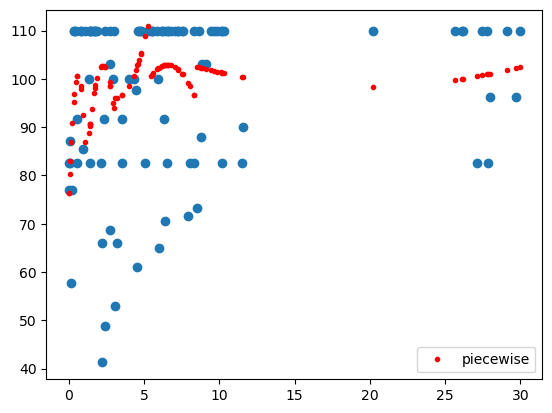

In [68]:
from mlinsights.mlmodel import PiecewiseRegressor

ms = PiecewiseRegressor("bins").fit(Xq_train.iloc[:,1:],Y_train)
=
plt.scatter(X_test,Y_test)

yHat_ms = ms.predict(Xq_test.iloc[:,1:])
plt.plot(X_test,yHat_ms,"r.",label="piecewise")

plt.legend()
plt.show()

Por ultimo, creamos un modelo KNN, donde definimos un valor de K como 15 para que vea sus 15 vecinos.


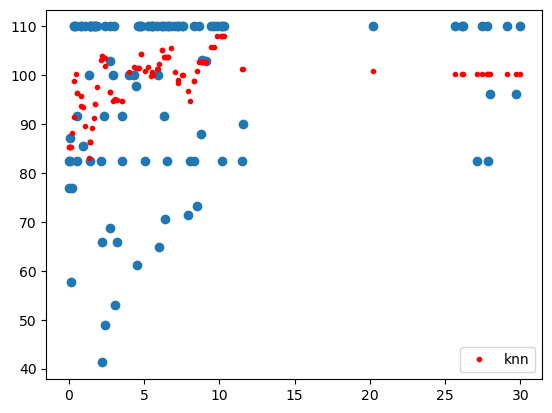

In [61]:
from sklearn.neighbors import KNeighborsRegressor as KNN

mk = KNN(n_neighbors=15).fit(Xtemp_train,Y_train)

yHat_mk = mk.predict(Xtemp_test)
plt.scatter(X_test,Y_test)

plt.plot(X_test,yHat_mk,"r.",label="knn")

plt.legend()
plt.show()

Una vez realizado cada modelo no lineal, buscaremos el RSE de cada uno de ellos para ver cual podria ser el que mejor se adapte a este conjunto de datos.

In [57]:
import numpy as np
#Poli
yHat_mq = mq.predict(Xq_test)
RSS_mq = sum((list(Y_test) - yHat_mq) ** 2)
RSE_mq = np.sqrt(RSS_mq / (len(Y_test)- 1))
print("RSE de modelo polinomial:",RSE_mq)

# Segmentada
RSS_ms = sum((list(Y_test)-yHat_ms)**2)
RSE_ms = np.sqrt(RSS_ms/(len(Y_test)-1))
print("RSE de modelo segmentado:",RSE_ms)

#KNN
RSS_mk = sum((list(Y_test)-yHat_mk)**2)
RSE_mk = np.sqrt(RSS_mk/(len(Y_test)-1))
print("RSE de modelo KNN:",RSE_mk)

RSE de modelo polinomial: 16.90728992094432
RSE de modelo segmentado: 17.309948228881176
RSE de modelo KNN: 17.512153107491883


Ahora que podemos ver los tres modelos en un mismo plano podemos ver que la polinomial pareciera adaptarce al comportamiento de los datos, donde sube y eventualmetne baja. En respecto a la segmentada y a la KNN parecieran ser las mismas pero la segmentada tiene la desventaja de que pareciera ser sobre ajuste al tener curvas muy marcadas y posiblemente si intentamos divir su funcion, deje de ser util. En conclusion, los tres modelos parecieran tener una buena relacion con los datos, pero si nos basamos en los RSE, el modelo polinomial tiene mayor significancia por una minima cantidad. No obstante, apesar de tener menor error, a mi consideracion, el modelo KNN tendria mas aplicacion en este tipo de datos, donde se pueden dividir en sub categorias de calificaciones en relacion a los tiempos, deficiendo asi el KNN como el "mejor".

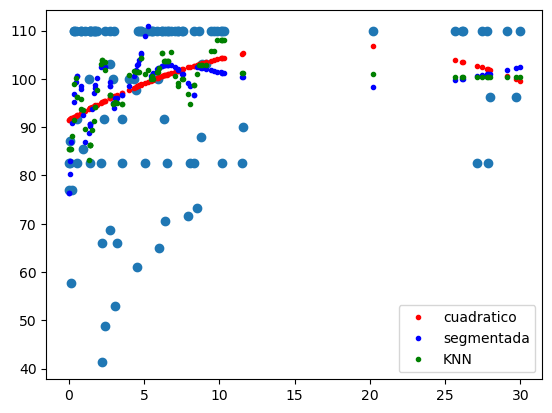

In [59]:
plt.scatter(X_test,Y_test)

plt.plot(X_test,yHat_mq,"r.",label="cuadratico")

plt.plot(X_test,yHat_ms,"b.",label="segmentada")

plt.plot(X_test,yHat_mk,"g.",label="KNN")

plt.legend()
plt.show()